# Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using ResNet18 as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the ResNet18 model pretrained on Imagenet dataset to extract ResNet18 activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from ResNet18 activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set. 
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord
# !git clone https://github.com/eldhusfifl07/nmaDL-project.git
# %cd /content/nmaDL-project/resnetBasline

current directory set to

```
# !git clone https://github.com/eldhusfifl07/nmaDL-project.git
```
Change directory to Baseline Run for output


In [4]:
#@title Imports
import glob
import numpy as np
import pandas as pd
import urllib
import torch
import cv2
import os
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import sys 
sys.path.append("../")
from tqdm import tqdm
# from utils import *

from torchvision import transforms as trn
import torchvision.models as models
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.autograd import Variable as V
from torch.utils.data import Dataset, DataLoader

import albumentations as A
# from albumentations.pytorch import ToTensorV2

from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from scipy.stats import ortho_group

from nilearn import datasets
from nilearn import surface
from nilearn import plotting

from decord import VideoReader
from decord import cpu






/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9). 

In [5]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
--2021-08-17 14:29:00--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/agxyxntrbwko7t1/participants_data.zip [following]
--2021-08-17 14:29:01--  https://www.dropbox.com/s/dl/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2d24f05ce4989b51f75e29bd2.dl.dropboxusercontent.com/cd/0/get/BUbxFTEdj2razE2FqiF6TDqaO4D7PTknnoAfLl1EWgAmog5bfai2_05dX3zQ6fVxo1PlENqg9nmAxImaJkgqaJtAVWpJh615dp507QJY4b4Rv4yshopGAvYDWIMG8sFR6brbbc16jMkorLBuGzaC92Yy/file?dl=1# [following]
--2021-08-17 14:29:01--  https://ucf2d24f05ce4989b51f75e29bd2.dl.dropboxusercontent.co

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [6]:
#@title Utility functions for data loading - need to download data for these functions
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021' 
  track = "full_track"
  results_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline'
  track_dir = os.path.join(fmri_dir, track) 
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [7]:
#@title Loading fMRI data and inspecting dimensions
# sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

# ROI = 'LOC'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

# ######## fMRI data loader wrapper code ###################################
# fmri_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/participants_data_v2021' 
# if ROI == "WB":
#     track = "full_track"
# else:
#     track = "mini_track"
# results_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/'
# track_dir = os.path.join(fmri_dir, track) 
# sub_fmri_dir = os.path.join(track_dir, sub)
# if track == "full_track":
#     fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
# else:
#     fmri_train_all = get_fmri(sub_fmri_dir,ROI)

# ######## fMRI data loader wrapper code ###################################


# f, ax = plt.subplots(figsize=(12, 5))
# ax.set(xlabel="Voxel", ylabel="Stimulus")
# heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
# f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
# f.tight_layout()

In [8]:
#@title Visualize video
# vid_id = 266 #@param {type: "integer"}
# video_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/AlgonautsVideos268_All_30fpsmax'

# ########### Video display code #################################################
# video_list = glob.glob(video_dir + '/*.mp4')
# video_list.sort()

# #visualize_brain_activity(video_dir,fmri_train_all,vid_id)
# from IPython.display import HTML
# from base64 import b64encode

# mp4 = open(video_list[vid_id],'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#     <source src="%s" type="video/mp4">
# </video>
# """ % data_url)
# ########### Video display code #################################################

In [9]:
#@title Visualize corresponding brain response
# visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model definition (ResNet18)

Run the next cell to define the architecture of the model using pytorch.

https://stackoverflow.com/questions/43175778/how-to-count-the-amount-of-layers-in-a-cnn

there are 20 convolution layers (one 7x7 conv, 16 3x3 conv, and plus 3 1x1 conv for downsample). Basically, if you ignore the 1x1 conv, and counting the FC (linear) layer, the number of layers are 18.

```
ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer2): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (downsample): Sequential (
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): BasicBlock (
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer3): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (downsample): Sequential (
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): BasicBlock (
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer4): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (downsample): Sequential (
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): BasicBlock (
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (avgpool): AvgPool2d (
  )
  (fc): Linear (512 -> 1000)
)
```




In [ ]:
model = models.resnet18(pretrained=True, progress=True)

checkpoint_path = "/content/resnet18.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/resnet18-f37072fd.pth"
    urllib.request.urlretrieve(url, "/content/resnet18.pth")
model_file = checkpoint_path
    # checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
if os.path.isfile(model_file):
  state_dict = torch.load(model_file,map_location=lambda storage, loc: storage)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
i = 0
for parameter in model.parameters():
  i += 1
  print(f'{i}th Parame = ', parameter.shape)


In [ ]:
for name, layer in model._modules.items():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
print(model.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [ ]:
#@title Visualise ResNet from https://gist.github.com/wangg12/f11258583ffcc4728eb71adc0f38e832

from graphviz import Digraph
from torch.autograd import Variable
import torch


def make_dot(var, params=None):
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                dot.edge(str(id(var.grad_fn)), str(id(var)))
                var = var.grad_fn
            if hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var)
    return dot



inputs = torch.randn(1, 3, 224, 224)
resnet18 = models.resnet18()
y = resnet18(inputs)
# print(y)

g = make_dot(y)
g.view()

'Digraph.gv.pdf'

In [ ]:
from torchsummary import summary

summary(model, input_size=(3,224,224))

#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [ ]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_resnet18(model_checkpoints):
    """This function initializes a ResNet18 and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of resnet18
    """
    model = models.resnet18(pretrained=True, progress=True)

    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict = ['conv1.weight', 'bn1.running_mean', 'bn1.running_var', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.running_mean', 'layer2.1.bn1.running_var', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.running_mean', 'layer2.1.bn2.running_var', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.running_mean', 'layer3.0.bn1.running_var', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.running_mean', 'layer3.0.bn2.running_var', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.running_mean', 'layer3.1.bn1.running_var', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 'layer3.1.conv2.weight', 'layer3.1.bn2.running_mean', 'layer3.1.bn2.running_var', 'layer3.1.bn2.weight', 'layer3.1.bn2.bias', 'layer4.0.conv1.weight', 'layer4.0.bn1.running_mean', 'layer4.0.bn1.running_var', 'layer4.0.bn1.weight', 'layer4.0.bn1.bias', 'layer4.0.conv2.weight', 'layer4.0.bn2.running_mean', 'layer4.0.bn2.running_var', 'layer4.0.bn2.weight', 'layer4.0.bn2.bias', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.1.conv1.weight', 'layer4.1.bn1.running_mean', 'layer4.1.bn1.running_var', 'layer4.1.bn1.weight', 'layer4.1.bn1.bias', 'layer4.1.conv2.weight', 'layer4.1.bn2.running_mean', 'layer4.1.bn2.running_var', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'fc.weight', 'fc.bias']
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1  
    # # checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    # if os.path.isfile(model_file):
    #   state_dict = torch.load(model_file,map_location=lambda storage, loc: storage)
    #   # best_acc = state_dict['acc']
    #   # print('Best Accuracy:', best_acc)
    #   if "state_dict" in state_dict:
    #       state_dict = state_dict["state_dict"]
    #   # remove prefixe "module."
    #   state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    #   for k, v in model.state_dict().items():
    #     if k not in list(state_dict):
    #       print('key "{}" could not be found in provided state dict'.format(k))
    #     elif state_dict[k].shape != v.shape:
    #       print('key "{}" is of different shape in model and provided state dict'.format(k))
    #       state_dict[k] = v
    #   msg = model.load_state_dict(state_dict, strict=False)
    #   print("Load pretrained model with msg: {}".format(msg))
    # else:
    #   raise Exception('No pretrained weights found')

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model
  

def print_resnet18_predictions(output):
    with open('/content/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    

def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
  """This function generates Alexnet features and save them in a specified directory.
  Parameters
  ----------
  model :
      pytorch model : resnet18.
  video_list : list
      the list contains path to all videos.
  activations_dir : str
      save path for extracted features.
  """
  
  resize_normalize = trn.Compose([
          trn.Resize((224,224)),
          trn.ToTensor(),
          trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  for video_file in tqdm(video_list):
      vid,num_frames = sample_video_from_mp4(video_file)
      video_file_name = os.path.split(video_file)[-1].split(".")[0]
             
      for frame,img in enumerate(vid):
          input_img = V(resize_normalize(img).unsqueeze(0))
          if torch.cuda.is_available():
              input_img=input_img.cuda()

          ##### HELPER FUNCTION FOR FEATURE EXTRACTION
          # a dict to store the activations
          features = {}
          PREDS = []
          activations = []

          def get_features(name):
              def hook(model, input, output):
                  features[name] = output.detach()
              return hook
          for name, layer in model._modules.items():
            layer.register_forward_hook(get_features(f'{name}'))
            # forward pass [with feature extraction]
            preds = model.forward(input_img)
            # add feats and preds to lists
            PREDS.append(preds.detach().cpu().numpy())
            activations.append(features[f'{name}'].cpu().numpy())

            
          # x = model.forward(input_img)
          for i,feat in enumerate(preds):
              if frame==0:
                  if i==7:
                      print("\nTop-5 Predictions for the video id: ", video_file_name)
                      print_resnet18_predictions(feat)

          #         activations.append(feat.data.cpu().numpy().ravel())
          #     else:
          #         activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()

      for layer in range(len(activations)):
          save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
          avg_layer_activation = activations[layer]/float(num_frames)
          np.save(save_path,avg_layer_activation)
  # return PREDS, FEATS

In [ ]:
#@title PCA code
def do_PCA_and_save(activations_dir, save_dir):
  """This function preprocesses Neural Network features using PCA and save the results
  in  a specified directory.
  Parameters
  ----------
  activations_dir : str
      save path for extracted features.
  save_dir : str
      save path for extracted PCA features.
  Returns: x_train 
  """
  layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8', 'layer_9', 'layer_10']
  n_components = 100

  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  for layer in tqdm(layers):
      activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
      activations_file_list.sort()
      feature_dim = np.load(activations_file_list[0])
      feature_dim = torch.flatten(feature_dim)
      x = np.zeros((len(activations_file_list),feature_dim.shape[0]))

      for i,activation_file in enumerate(activations_file_list):
          temp = np.load(activation_file)
          x[i,:] = temp
      x_train = x[:1000,:]
      x_test = x[1000:,:]

      start_time = time.time()
      x_test = StandardScaler().fit_transform(x_test)
      x_train = StandardScaler().fit_transform(x_train)
      ipca = PCA(n_components=n_components,random_state=seed)
      ipca.fit(x_train)

      x_train = ipca.transform(x_train)
      x_test = ipca.transform(x_test)
  return x_train  # just so it will match the rest of the code

  

def plot_principal_component(pca, i):
  # Get PC representation as a subspace with size proportional to the corresponding singular value
  size = np.sqrt(pca.singular_values_[i])
  pc = np.outer(pca.components_[i], np.array([-1,1])) * size
  color_scheme = ["rgb(189,6,96)", "rgb(6,189,99)", "rgb(6,96,189)"]

  return go.Scatter3d(x=pc[0], y=pc[1], z=pc[2], mode="lines", opacity=.5,
                        line=dict(color=color_scheme[i], width=2*size), name='PC {}'.format(i+1))

In [ ]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
# video_list = glob.glob(video_dir + '/0001_0-0-1-6-7-2-8-0-17500167280.mp4')
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/activations_resnet18"

checkpoint_path = "/content/resnet18.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/resnet18-f37072fd.pth"
    urllib.request.urlretrieve(url, "/content/resnet18.pth")
model = load_resnet18(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")

get_activations_and_save(model, video_list, activations_dir)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


  0%|          | 0/1102 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 84%|████████▍ | 923/1102 [5:24:51<2:05:38, 42.12s/it]

In [ ]:
layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8', 'layer_9', 'layer_10']
for layer in layers:
  x = np.load(f"/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/activations_resnet18/0001_0-0-1-6-7-2-8-0-17500167280_{layer}.npy")
  print(x.shape)

(1, 64, 112, 112)
(1, 64, 112, 112)
(1, 64, 112, 112)
(1, 64, 56, 56)
(1, 64, 56, 56)
(1, 128, 28, 28)
(1, 256, 14, 14)
(1, 512, 7, 7)
(1, 512, 1, 1)
(1, 1000)


In [ ]:
!cd #to working dir
!pip install patool
import patoolib
patoolib.extract_archive("layer_{}.rar", outdir="path here") 


In [ ]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
X = do_PCA_and_save(activations_dir, pca_dir)

In [ ]:
def do_PCA(activations_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_5']
    n_components = 100
    for layer in layers:
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        start_time = time.time()
        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=np.random.seed(1))
        ipca.fit(x)

        x = ipca.transform(x)

        return x

        
X = do_PCA('activations_alexnet')

In [ ]:
from pandas import DataFrame

pca = PCA(n_components=3).fit(X) # change the number of n_components to search for the best subspace

ev = pca.singular_values_**2
DataFrame(np.array([ev, ev/sum(ev), pca.explained_variance_ratio_]),
          columns=["PC 1", "PC 2", "PC3"],
          index=["Eigenvalues", "Explained Variance", "sklearn's Explained Variance"])
variance = list(np.around(100*pca.explained_variance_ratio_, 2)) + [100]

fig = make_subplots(rows=1, cols=2, subplot_titles=[r"$\text{Eigenvalues}$", r"$\text{Cumulative Explained Variance}$"],
                    specs=[[{'type': 'Bar'}, {'type': 'Waterfall'}]])

fig.add_traces([go.Bar(x=['PC1', 'PC2', 'PC3'], y=pca.singular_values_, marker_color = color_scheme),
                go.Waterfall(x=["PC1", "PC2", "PC3", "Total"],
                             y=variance,
                             text=[f"{v}%" for v in variance],
                             textposition = "outside",
                             totals = {"marker":{"color":"black"}},
                             measure = ["relative", "relative", "relative", "total"])],
               rows=[1,1], cols=[1,2])

fig.add_shape(type="rect", xref="x", yref="y", x0=-0.4, x1=0.4, y0=0.0, y1=fig.data[1].y[0], 
              fillcolor=color_scheme[0], line=dict(color=color_scheme[0]), opacity=1,row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=0.6, x1=1.4, y0=fig.data[1].y[0], y1=fig.data[1].y[0]+fig.data[1].y[1],
              fillcolor=color_scheme[1], line=dict(color=color_scheme[1]), opacity=1, row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=1.6, x1=2.4, y0=fig.data[1].y[0]+fig.data[1].y[1], y1=fig.data[1].y[0]+fig.data[1].y[1]+fig.data[1].y[2], 
              fillcolor=color_scheme[2], line=dict(color=color_scheme[2]), opacity=1, row=1, col=2)

fig.update_layout(showlegend=False, title=r"$\text{(4) PCA Explained Variance}$", margin=dict(t=100))
fig.show()

In [11]:
#@title Ridge Regression and Cross-Validation
#from SemanticModel import SemanticModel
#from ridge import bootstrap_ridge

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# load the dataset
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
data_PCA_1 = np.load('/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetPCAs/pca_new/test_layer_3.npy')

# define model
model_Reg = Ridge(alpha=1.0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model

data = data_PCA_1.values
X, y = data[:, :-1], data[:, -1]

scores = cross_val_score(model_Reg, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

AttributeError: ignored

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 



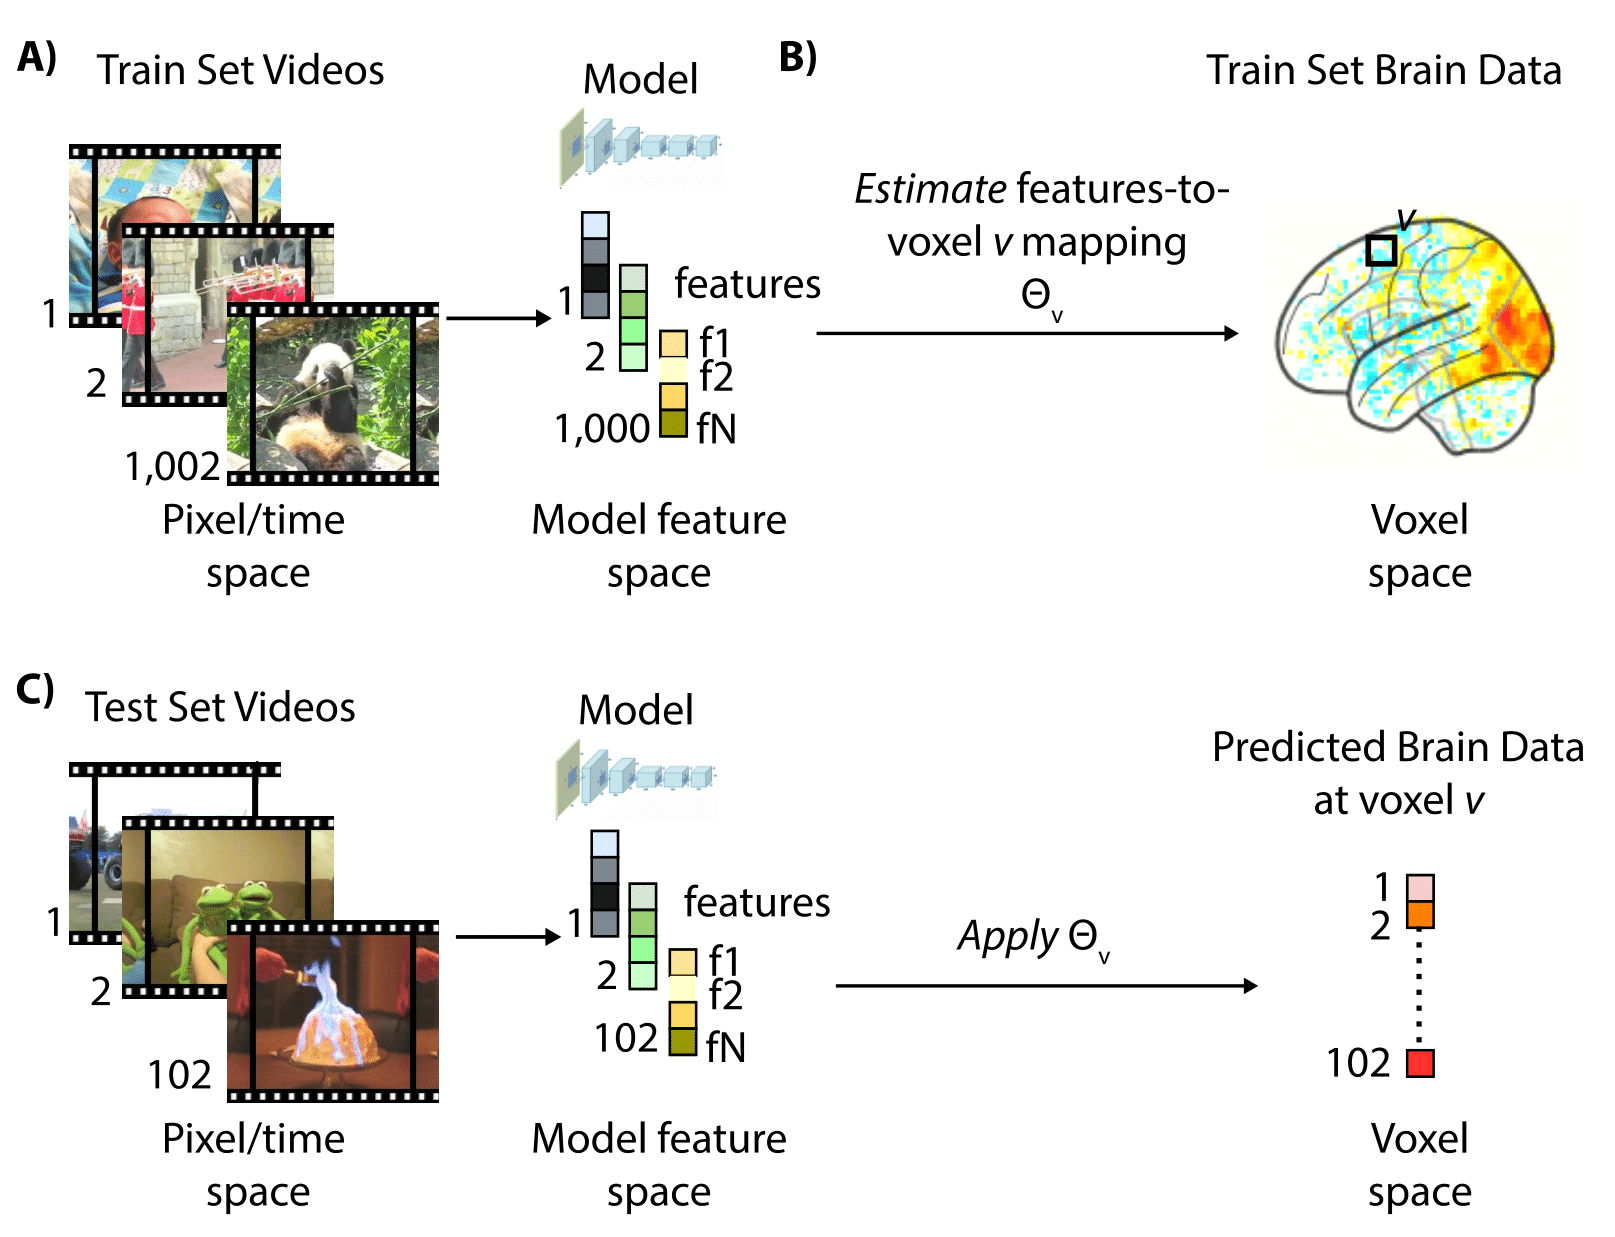

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

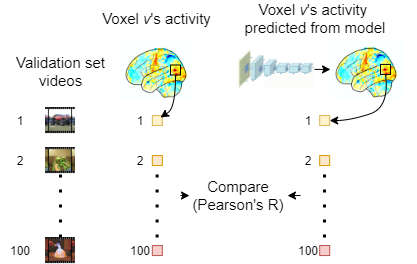

In [ ]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    # betas = reg.coef_
    # np.savez_compressed(betas)
    return fmri_pred_test

            

In [ ]:
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/activations_resnet18'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)


# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

fmri_dir = '/content/participants_data_v2021'
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/prediction'
model = 'resnet18'

for layer in layers:
  for sub in subs:
    for ROI in ROIs:
      if ROI == "WB":
          track = "full_track"
      else:
          track = "mini_track"
      results_dir = os.path.join(prediction_dir,model, layer,\
                            track, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      print ("Starting ROI: ", ROI, "sub: ",sub)
      perform_encoding(activations_dir, fmri_dir,\
                      results_dir, sub, layer,\
                      ROI=ROI,mode='test')
      print ("Completed ROI: ", ROI, "sub: ",sub)
      print("----------------------------------------------------------------------------")

In [ ]:

subIDs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB"]
# ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

df = np.zeros((len(subIDs),len(ROIs)))
for layer in layers:
  for i, subID in enumerate(subIDs): 
    for j, ROI in enumerate(ROIs):
      outnp = np.load(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/prediction/resnet18/{layer}/full_track/{subID}/{ROI}_test.npy')
      # outnp = np.load(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/prediction/resnet18/{layer}/mini_track/{subID}/{ROI}_test.npy')
      # print(outnp.shape)
      mn = outnp.mean()
      df[i,j] = mn

  print(df.shape)

  # plt.imshow(df, cmap='hot')

  pos = np.arange(0,9)
  plt.figure(figsize=(15,8))
  plt.boxplot(df, labels = ROIs)
  plt.title(f'{layer}')
  plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/prediction/resnet18/BoxPlots/{layer}_full.png')
    # plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DumboOctopi/AlgonautsDataExtraction/resnetBasline/prediction/resnet18/BoxPlots/{layer}_mini.png')
  plt.show()

In [ ]:
# lay8 = plt.imread('/content/prediction/resnet18/results/layer8_mini.png')
# plt.figure(figsize=(15,8))
# plt.imshow(lay8)

#Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)


